In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,precision_recall_curve, roc_auc_score, roc_curve


sns.set_style(style="whitegrid")

In [29]:
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [31]:
data["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [32]:
imbalance = data["Class"].value_counts()[1] / data["Class"].value_counts()[0]
print(f"Imbalance ratio: {imbalance}")

Imbalance ratio: 0.0017304750013189597


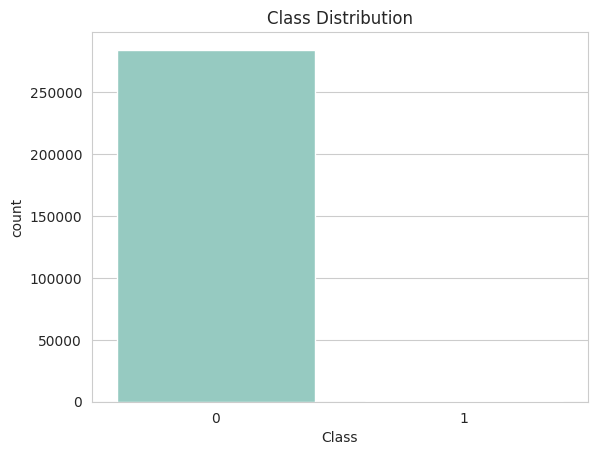

In [33]:
sns.countplot(x="Class", data=data)
plt.title("Class Distribution")
plt.show()

In [34]:
data = data.drop("Time", axis=1)

<Axes: xlabel='Amount', ylabel='Density'>

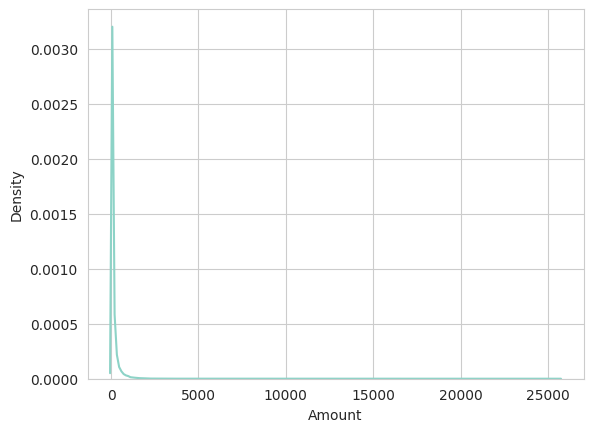

In [35]:
sns.kdeplot(x=data["Amount"])

In [36]:
scaler = StandardScaler()
data["Amount"] = scaler.fit_transform(data["Amount"].values.reshape(-1, 1))

In [37]:
X = data.drop("Class", axis=1)
y = data["Class"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Isolation Forest


In [38]:
iso_forest = IsolationForest(
    contamination=0.00173, random_state=42
)  # Contamination is approximately the proportion of outliers
iso_forest.fit(X_train)
y_pred_iso = iso_forest.predict(X_test)
y_pred_iso[y_pred_iso == 1] = 0  # Convert 1 to 0 (normal)
y_pred_iso[y_pred_iso == -1] = 1  # Convert -1 to 1 (anomaly)

print("Isolation Forest Results:")
print(classification_report(y_test, y_pred_iso))
print(confusion_matrix(y_test, y_pred_iso))

Isolation Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.25      0.26      0.25        98

    accuracy                           1.00     56962
   macro avg       0.62      0.63      0.62     56962
weighted avg       1.00      1.00      1.00     56962

[[56788    76]
 [   73    25]]


Isolation Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.26      0.30      0.28        98

    accuracy                           1.00     56962
   macro avg       0.63      0.65      0.64     56962
weighted avg       1.00      1.00      1.00     56962

[[56782    82]
 [   69    29]]
0.6472381651028448


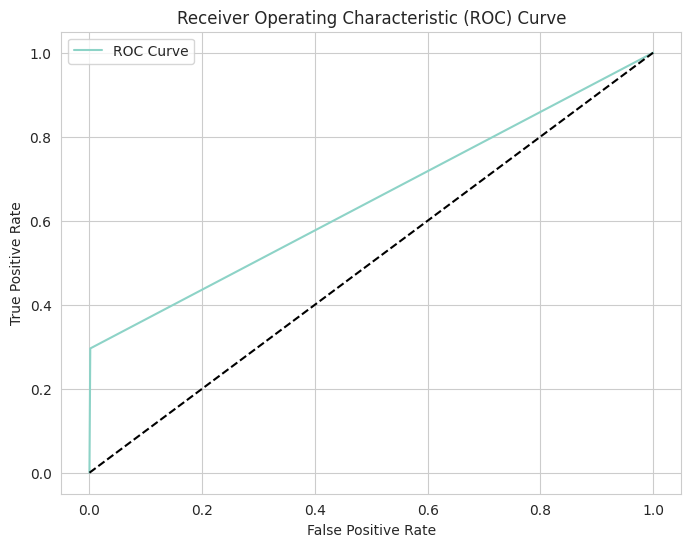

[0.00172045 0.26126126 1.        ] [1.         0.29591837 0.        ] [0 1]


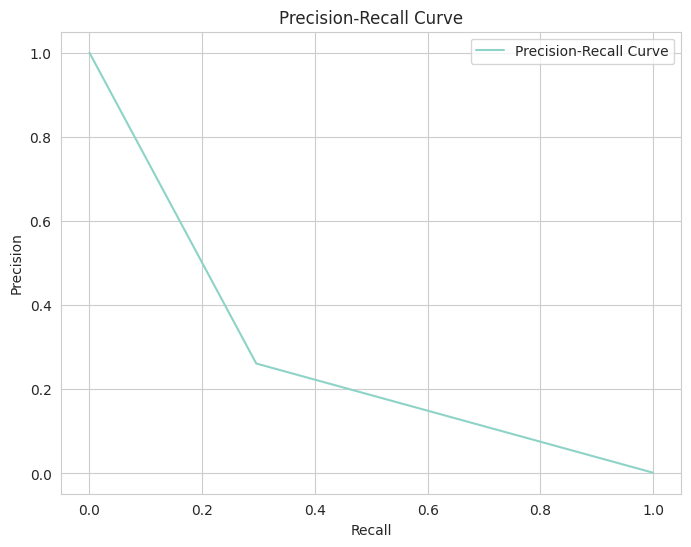

In [39]:
iso_forest = IsolationForest(
    contamination=0.002,  # Slightly higher contamination
    n_estimators=500,  # More trees for better anomaly detection
    max_samples=256,  # Smaller sample size to detect rare patterns
    random_state=42,
)
iso_forest.fit(X_train)
y_pred_iso = iso_forest.predict(X_test)
y_pred_iso[y_pred_iso == 1] = 0  # Convert 1 to 0 (normal)
y_pred_iso[y_pred_iso == -1] = 1  # Convert -1 to 1 (anomaly)

print("Isolation Forest Results:")
print(classification_report(y_test, y_pred_iso))
print(confusion_matrix(y_test, y_pred_iso))
print(roc_auc_score(y_test, y_pred_iso))
roc_auc = roc_curve(y_test, y_pred_iso)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(roc_auc[0], roc_auc[1], label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_iso)
print(precision, recall, thresholds)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# balancing the dataset

In [40]:
# SMOTE
smote = SMOTE(sampling_strategy=0.5, k_neighbors=5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Random Undersampling
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [41]:
# Hybrid Sampling - SMOTEENN
smoteenn = SMOTEENN(sampling_strategy=0.01, random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

In [42]:
# Hybrid Sampling - SMOTETomek
smotetomek = SMOTETomek(sampling_strategy=0.01, random_state=42)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train, y_train)

In [ ]:
# Logistic Regression
logreg = LogisticRegression(random_state=42, max_iter=1000)

# Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)

results = {}

datasets = {
    "Original": (X_train, y_train),
    "SMOTE": (X_train_smote, y_train_smote),
    "Random Undersampling": (X_train_rus, y_train_rus),
    "Hybrid smoteenn": (X_train_smoteenn, y_train_smoteenn),
    "Hybrid smotetomek": (X_train_smotetomek, y_train_smotetomek),
}

for name, (X_train_data, y_train_data) in datasets.items():
    logreg.fit(X_train_data, y_train_data)
    y_pred_logreg = logreg.predict(X_test)
    results[f"Logistic Regression ({name})"] = {
        "classification_report": classification_report(y_test, y_pred_logreg),
        "confusion_matrix": confusion_matrix(y_test, y_pred_logreg),
    }

    rf.fit(X_train_data, y_train_data)
    y_pred_rf = rf.predict(X_test)
    results[f"Random Forest ({name})"] = {
        "classification_report": classification_report(y_test, y_pred_rf),
        "confusion_matrix": confusion_matrix(y_test, y_pred_rf),
        "roc_auc_score": roc_auc_score(y_test, y_pred_rf)        
    }

for model_name, metrics in results.items():
    print(f"\n{model_name} Results:")
    print(metrics["classification_report"])
    print(metrics["confusion_matrix"])
    print(metrics["roc_auc_score"])



Logistic Regression (Original) Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.57      0.68        98

    accuracy                           1.00     56962
   macro avg       0.92      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962

[[56854    10]
 [   42    56]]

Random Forest (Original) Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.77      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962

[[56862     2]
 [   23    75]]

Logistic Regression (SMOTE) Results:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.12      0.92      0.21        98

    ac

In [44]:
scale_pos_weight = (len(y_train_smoteenn) - sum(y_train_smoteenn)) / sum(y_train_smoteenn)

In [45]:
xgb_classifier_smote = xgb.XGBClassifier(
    random_state=42, n_estimators=100, scale_pos_weight=scale_pos_weight
)
xgb_classifier_smote.fit(X_train_smote, y_train_smote)
y_pred_xgb = xgb_classifier_smote.predict(X_test)
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print(roc_auc_score(y_test, y_pred_xgb))
print(roc_curve( y_test, y_pred_xgb))
precision_recall_curve(y_test, y_pred_xgb)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.58      0.88      0.70        98

    accuracy                           1.00     56962
   macro avg       0.79      0.94      0.85     56962
weighted avg       1.00      1.00      1.00     56962

[[56801    63]
 [   12    86]]
0.9382215569120163
(array([0.        , 0.00110791, 1.        ]), array([0.        , 0.87755102, 1.        ]), array([inf,  1.,  0.]))


(array([0.00172045, 0.57718121, 1.        ]),
 array([1.        , 0.87755102, 0.        ]),
 array([0, 1]))

In [46]:
xgb_classifier_smoteenn = xgb.XGBClassifier(
    random_state=42, n_estimators=100, scale_pos_weight=scale_pos_weight
)
xgb_classifier_smoteenn.fit(X_train_smoteenn, y_train_smoteenn)
y_pred_xgb = xgb_classifier_smoteenn.predict(X_test)
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print(roc_auc_score(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962

[[56851    13]
 [   16    82]]
0.9182530391166033


In [ ]:
xgb_classifier_smotetomek = xgb.XGBClassifier(
    random_state=42, n_estimators=100, scale_pos_weight=scale_pos_weight
)
xgb_classifier_smotetomek.fit(X_train_smotetomek, y_train_smotetomek)
y_pred_xgb = xgb_classifier_smotetomek.predict(X_test)
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print(roc_auc_score(y_test, y_pred_xgb))
roc_auc = roc_curve(y_test, y_pred_xgb)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(roc_auc[0], roc_auc[1], label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_xgb)
print(precision, recall, thresholds)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.83      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962

[[56856     8]
 [   17    81]]


# Resluts
* the best model is xgboost with smotetomek method which is a hybrid method of smote and tomek links
* the 2nd best model is random forest with smotetomek method which is a hybrid method of smote and tomek links